# E-Commerce Sales & Product Health Check – Demo 02

**Objective:**  
Audit revenue, refunds, and pricing volatility in a real-world retail dataset.

**Business Value:**  
Identify refund-heavy SKUs, top revenue drivers, and pricing inconsistencies to support profit optimization and stock strategy.

In [1]:
from IPython.display import Markdown, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set number formatting
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Seaborn & plot style
plt.style.use('seaborn-whitegrid')
sns.set_palette('pastel')

In [2]:
df = pd.read_csv('../data/online_retail_II.csv', encoding='ISO-8859-1')

In [3]:
# Basic engineering
df['Total'] = df['Quantity'] * df['Price']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,YearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00,2009-12


In [4]:
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
df.info()

Rows: 1,067,371 | Columns: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   Total        1067371 non-null  float64       
 9   YearMonth    1067371 non-null  period[M]     
dtypes: datetime64[ns](1), float64(3), int64(1), object(4), period[M](1)
memory usage: 81.4+ MB


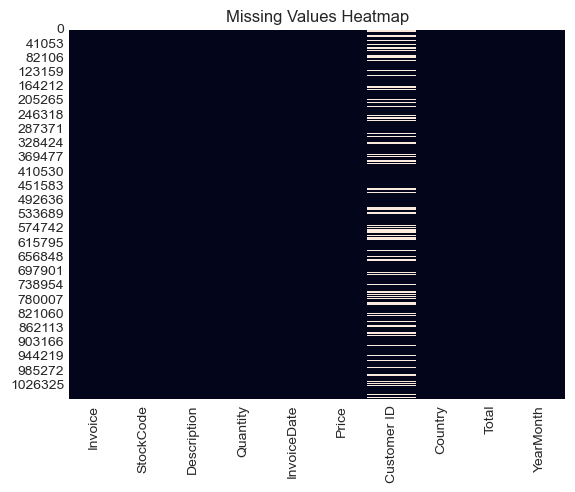

❗ Duplicates: 34,335


In [5]:
# Nulls
df.isnull().sum().sort_values(ascending=False)

# Visual null heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Duplicates
print(f"❗ Duplicates: {df.duplicated().sum():,}")

In [6]:
df.describe(include='all')

/var/folders/5v/0jcqqxwn2j35ftms2lfr91n40000gn/T/ipykernel_3874/2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,YearMonth
count,1067371,1067371,1062989,1067371.00,1067371,1067371.00,824364.00,1067371,1067371.00,1067371
unique,53628,5305,5698,NaN,47635,NaN,NaN,43,NaN,25
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-06 16:57:00,NaN,NaN,United Kingdom,NaN,2011-11
freq,1350,5829,5918,NaN,1350,NaN,NaN,981330,NaN,84711
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.94,NaN,4.65,15324.64,NaN,18.07,NaN
std,NaN,NaN,NaN,172.71,NaN,123.55,1697.46,NaN,292.42,NaN
min,NaN,NaN,NaN,-80995.00,NaN,-53594.36,12346.00,NaN,-168469.60,NaN
25%,NaN,NaN,NaN,1.00,NaN,1.25,13975.00,NaN,3.75,NaN


## Refund Analysis

In [7]:
refunds = df[df['Quantity'] < 0]
summary = pd.DataFrame({
    "Metric": [
        "Total Records",
        "Unique Customers",
        "Refund Volume (€)",
        "Refund Rate (%)",
        "Volatile Price Products (3+ prices)"
    ],
    "Value": [
        f"{len(df):,}",
        df['Customer ID'].nunique(),
        f"{refunds['Total'].sum():,.2f}",
        round(len(refunds) / len(df) * 100, 2),
        df.groupby('Description')['Price'].nunique().gt(3).sum()
    ]
})

summary.style.set_properties(**{
    'background-color': '#f8f9fa',
    'color': 'black',
    'border-color': 'lightgray'
}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt'), ('text-align', 'left')]
}])


,Metric,Value
0,Total Records,"1,067,371"
1,Unique Customers,5942
2,Refund Volume (€),"-1,527,041.43"
3,Refund Rate (%),2.150000
4,Volatile Price Products (3+ prices),3263


In [8]:
print("Refund Analysis")
print(f"Total Refunds: {refunds.shape[0]}")
print(f"Refund %: {round(len(refunds)/len(df)*100, 2)}%")
print(f"Refund Value: €{refunds['Total'].sum():,.2f}")

Refund Analysis
Total Refunds: 22950
Refund %: 2.15%
Refund Value: €-1,527,041.43


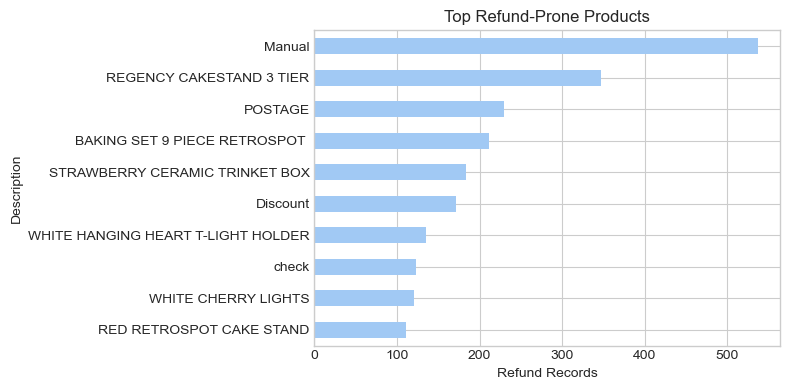

In [9]:
refund_counts = df[df['Quantity'] < 0].groupby('Description')['Quantity'].count().sort_values(ascending=False)
refund_counts.head(10).plot(kind='barh', figsize=(8, 4), title="Top Refund-Prone Products")
plt.xlabel("Refund Records")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Top-Selling Products

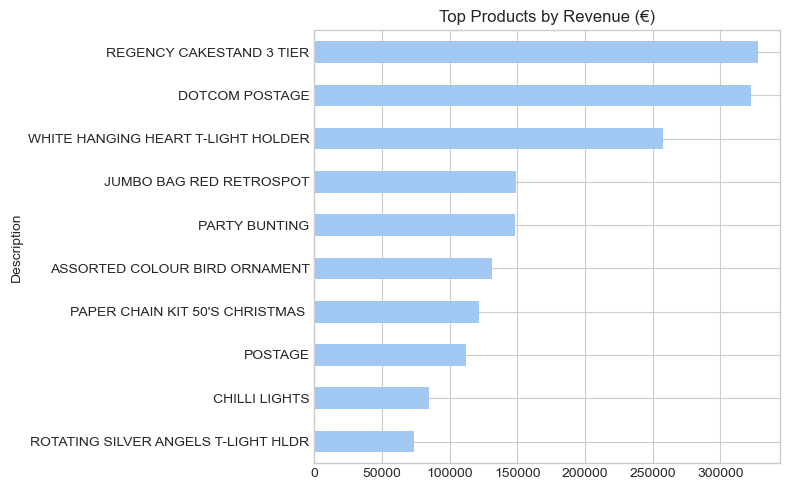

In [10]:
#Top selling products by revenue 
top_products = df.groupby('Description')['Total'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title='Top Products by Revenue (€)', figsize=(8,5))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Pricing Volatility

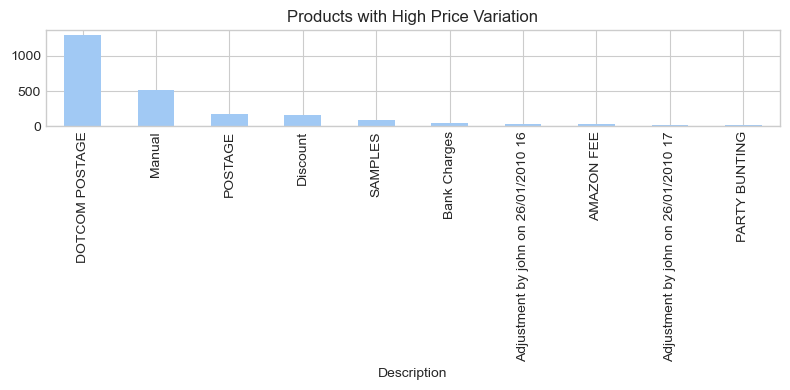

In [11]:
#Group SKUs according to their price, and filter if they had more than 3 prices
price_variation = df.groupby('Description')['Price'].nunique().sort_values(ascending=False)
volatile = price_variation[price_variation > 3].head(10)

volatile.plot(kind='bar', figsize=(8,4), title='Products with High Price Variation')
plt.tight_layout()
plt.show()

In [12]:
volatile_skus = price_variation[price_variation > 3].sort_values(ascending=False)

print("Products with High Price Variation (Top 10)")
display(volatile_skus.head(10))

Products with High Price Variation (Top 10)


Description
DOTCOM POSTAGE                         1291
Manual                                  514
POSTAGE                                 179
Discount                                162
SAMPLES                                  94
Bank Charges                             55
Adjustment by john on 26/01/2010 16      35
AMAZON FEE                               30
Adjustment by john on 26/01/2010 17      25
PARTY BUNTING                            19
Name: Price, dtype: int64

## Revenue Trends

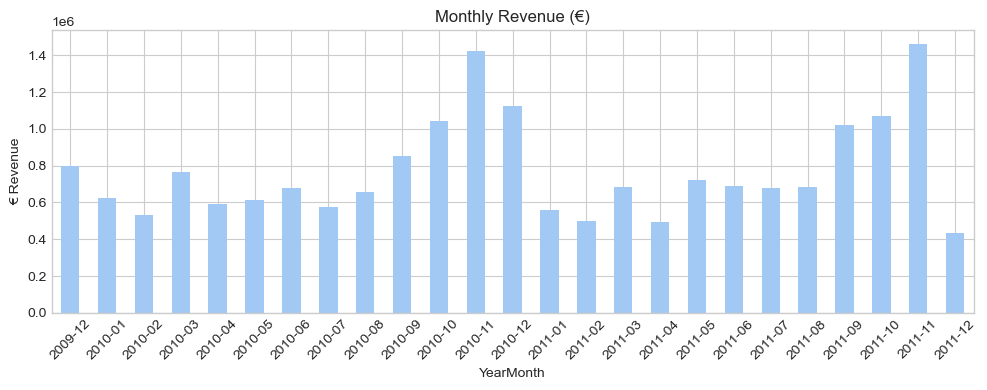

In [13]:
# Bar chart for monthly revenue
monthly_sales = df.groupby('YearMonth')['Total'].sum()
monthly_sales.plot(kind='bar', figsize=(10, 4), title='Monthly Revenue (€)', ylabel='€ Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cleaning Recommendations

- Investigate refund-heavy SKUs for root cause (return policy, delivery issues).
- Flag products with unusually high price variation for pricing normalization.
- Drop rows with negative quantities for clean revenue calculations.
- Normalize product naming conventions if used in dashboards or reports.

In [14]:
# Initial counts
initial_rows = len(df)
refund_rows = (df['Quantity'] < 0).sum()
duplicate_rows = df.duplicated().sum()
null_rows = df.isnull().any(axis=1).sum()

# Apply all cleaning
df_clean = df[df['Quantity'] > 0].copy()
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

# Cleaned shape
cleaned_rows = len(df_clean)

In [15]:
# Display summary
display(Markdown(f"""
### Data Cleaning Summary

- **Original Rows**: {initial_rows:,}  
- **Refund Rows Removed** (`Quantity < 0`): {refund_rows:,}  
- **Duplicate Rows Removed**: {duplicate_rows:,}  
- **Rows with Missing Values**: {null_rows:,}  
- **Rows After Cleaning**: **{cleaned_rows:,}**
"""))


### Data Cleaning Summary

- **Original Rows**: 1,067,371  
- **Refund Rows Removed** (`Quantity < 0`): 22,950  
- **Duplicate Rows Removed**: 34,335  
- **Rows with Missing Values**: 243,007  
- **Rows After Cleaning**: **779,495**


In [16]:
# Flag volatile pricing products for normalization
df_clean['VolatilePricing'] = df_clean['Description'].isin(volatile_skus.index)

# Strip & title-case descriptions to normalize
df_clean['Description'] = df_clean['Description'].str.strip().str.title()

# Preview cleaned structure
df_clean[['Description', 'Price', 'VolatilePricing']].sample(5)


,Description,Price,VolatilePricing
388824,Memo Board Retrospot Design,4.95,True
479183,Apron Apple Delight,4.95,True
626839,Travel Card Wallet Keep Calm,0.42,True
940668,3 Raffia Ribbons 50'S Christmas,0.79,False
51579,Pink Paisley Rose Gift Wrap,0.42,False


### Key Takeaways – Demo 02

- **Revenue Concentration**: A small subset of products contributes disproportionately to total revenue.
- **Refund Risk**: Over 2% of all transactions are refunds, totaling more than €1.5M in lost revenue.
- **Price Inconsistency**: Several products (e.g., DOTCOM POSTAGE) show high pricing volatility, suggesting inconsistent data or margin control issues.
- **Seasonality & Trends**: Strong peaks in November suggest seasonal campaigns drive large chunks of annual revenue, such as Black Friday
- **Cleaning Opportunities**: The dataset contains negative quantities, price anomalies, and product naming inconsistencies — all of which may impact downstream reporting or ML forecasting.

**Next Steps**:
- Prioritize price normalization for high-variance SKUs  
- Create refund-based product flags in your CRM  
- Use monthly and seasonal trends to guide promotional planning 

In [17]:
df_clean.to_csv("../data/cleaned_ecom_data.csv", index=False)